# Walmart Sales Forecast
This notebook explores the sales data of 45 Wal-Mart locations. Exploritory data analysis was perfomed at the store and deparment level and the finding were used to forecast the sales.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio

import pandas as pd
import numpy as np
import datetime

# 1. Data Imports and Manipulation
The sales and store data was collected from [Walmart Recruiting's Kaggle Competition](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting). This dataset only includes the influence of 4 holidays. Entering this project with the assumption that consumer spending is heavily influenced by holidays so a [second source](https://www.timeanddate.com/holidays/us/2010?hol=17) was utilized to collect all relevant consumer events and commonly observed U.S. holidays. The datasets were then consolidated in a [separate script](https://github.com/octaviaisom/Walmart-Sales-Forecast/blob/master/holidates.py) (due to its extended runtime) and saved in ``` sales_updated.csv ```.

In [3]:
csv = pd.read_csv("data/holidays.csv")
holidays = pd.DataFrame(csv)

holidays.head()

,Holiday,Date
0,Black Friday,2010-11-26
1,Black Friday,2011-11-25
2,Black Friday,2012-11-23
3,Black Friday,2013-11-29
4,Christmas Day,2010-12-25


In [4]:
holidays.Date = pd.to_datetime(holidays.Date)

In [5]:
#walmart's
csv = pd.read_csv("data/sales.csv")
sales = pd.DataFrame(csv)

sales.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,2012-09-28,508.37,False
421566,45,98,2012-10-05,628.10,False
421567,45,98,2012-10-12,1061.02,False
421568,45,98,2012-10-19,760.01,False
421569,45,98,2012-10-26,1076.80,False


In [6]:
sales.Date = pd.to_datetime(sales.Date)

In [7]:
#all
csv = pd.read_csv("data/sales_updated.csv")
sales_all = pd.DataFrame(csv)

sales_all.tail()

,Store,Dept,Date,Weekly_Sales,IsHoliday
421565,45,98,9/28/2012,508.37,False
421566,45,98,10/5/2012,628.10,False
421567,45,98,10/12/2012,1061.02,False
421568,45,98,10/19/2012,760.01,False
421569,45,98,10/26/2012,1076.80,False


In [8]:
sales_all.Date = pd.to_datetime(sales.Date)

In [9]:
sales.info()
sales.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null datetime64[ns]
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


In [10]:
csv = pd.read_csv("data/stores.csv")
stores = pd.DataFrame(csv)

stores.tail()

,Store,Type,Size
40,41,A,196321
41,42,C,39690
42,43,C,41062
43,44,C,39910
44,45,B,118221


In [11]:
stores.info()
stores.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
Store    45 non-null int64
Type     45 non-null object
Size     45 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Size
count,45.000000,45.000000
mean,23.000000,130287.600000
std,13.133926,63825.271991
min,1.000000,34875.000000
25%,12.000000,70713.000000
50%,23.000000,126512.000000
75%,34.000000,202307.000000
max,45.000000,219622.000000


# 2. EDA

In [12]:
#setting color pallete for charts
pio.templates.default = "plotly_white"
palette = flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(palette)

plt.style.use('seaborn-darkgrid')


## Record Counts
Review missing values

In [13]:
sales.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
dtype: int64

In [14]:
45*81*143 == len(sales)

False

In [15]:
#Departments with missing weekly sales
sales.groupby('Dept').nunique().query("Date<143")

,Store,Dept,Date,Weekly_Sales,IsHoliday
Dept,,,,,
39,5,1,16,12,2
43,5,1,12,6,2
47,37,1,138,277,2
51,37,1,131,780,2
77,37,1,35,58,2
78,37,1,82,38,2
99,37,1,94,311,2


In [16]:
#Stores with missing weekly sales
sales.groupby('Store').nunique().query("Date<143")

,Store,Dept,Date,Weekly_Sales,IsHoliday
Store,,,,,


In [82]:
#Number of unique depts per store
#sales.groupby('Store').nunique().sort_values(['Dept'])

## Sales Analysis
High-level analysis of sales and holiday's potential influence on seasonality

In [18]:
byDate = sales.groupby('Date',sort=False).sum()
byDate.IsHoliday = byDate.IsHoliday.astype('bool').astype('int')
byDate.index.freq = 'W-FRI'
byDate.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0
2010-02-12,65082,131179,48336677.63,1
2010-02-19,65610,131897,48276993.78,0
2010-02-26,65045,130161,43968571.13,0
2010-03-05,64897,129670,46871470.30,0


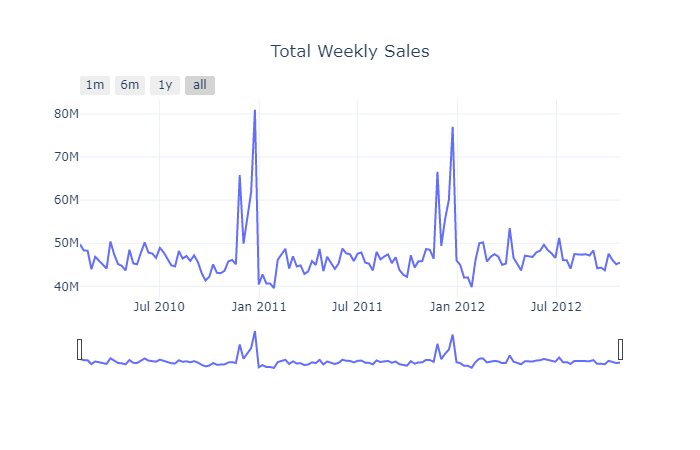

In [19]:
line = go.Figure(data=go.Scatter(x=byDate.index,y=byDate.Weekly_Sales, name='Weekly_Sales'))
line.update_layout(title={
        'text': "Total Weekly Sales",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}
)
line.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
line.show("png")
#line.show()

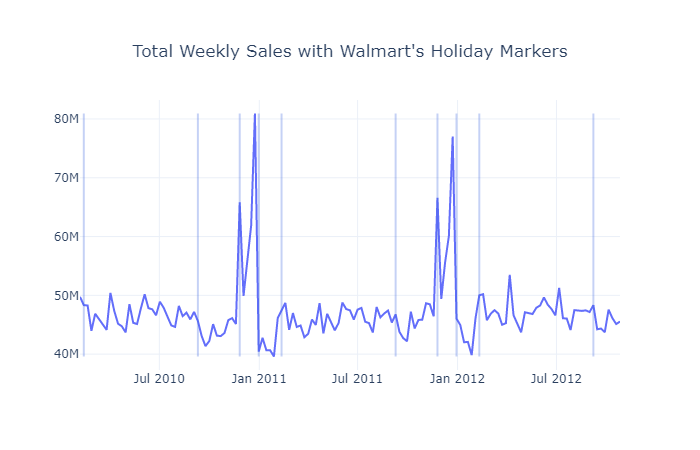

In [20]:
ymin=byDate.Weekly_Sales.min()
ymax=byDate.Weekly_Sales.max()

lin = go.Figure(data=go.Scatter(x=byDate.index,y=byDate.Weekly_Sales, name='Weekly_Sales'))

final_wk = max(byDate.index)
for date in byDate.query("IsHoliday==1").index:
    lin.add_shape(type="line",
                   x0=date,
                   y0=ymin,
                   x1=date,
                   y1=ymax,
                   opacity=0.3,
                  line=dict(color="RoyalBlue"))

lin.update_layout(title={
        'text': "Total Weekly Sales with Walmart's Holiday Markers",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
lin.show('png')
#lin.show()

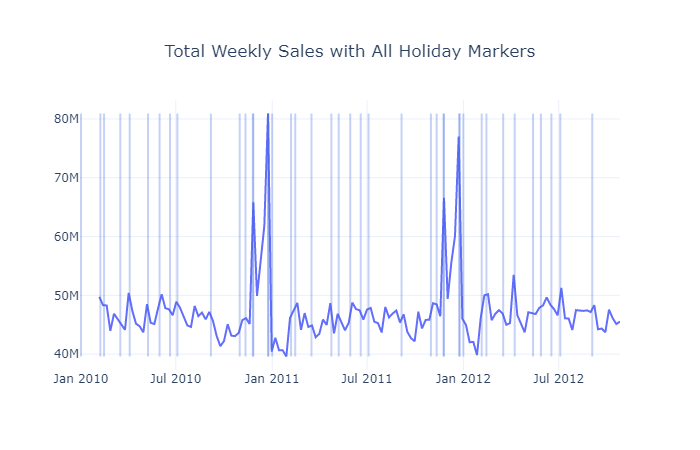

In [21]:
lin = go.Figure(data=go.Scatter(x=byDate.index,y=byDate.Weekly_Sales, name='Weekly_Sales'))

final_wk = max(byDate.index)
for index, row in holidays[holidays.Date <= final_wk].iterrows():
    lin.add_shape(type="line",
                   x0=row['Date'],
                   y0=ymin,
                   x1=row['Date'],
                   y1=ymax,
                   opacity=0.3,
                  line=dict(color="RoyalBlue"))

lin.update_layout(title={
        'text': "Total Weekly Sales with All Holiday Markers",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
lin.show('png')
#lin.show()

Day-of and trailing/leading

# Sales by Store
How does the stores' size/type influences sales?

In [22]:
byStore = sales.reset_index().groupby('Store', as_index=False).sum()
byStore = pd.merge(byStore, stores, on='Store', how='left')
byStore.head()

,Store,index,Dept,Weekly_Sales,IsHoliday,Type,Size
0,1,52464646,454749,2.224028e+08,723.0,A,151315
1,2,157281275,455425,2.753824e+08,722.0,A,202307
2,3,225895482,370825,5.758674e+07,633.0,B,37392
3,4,355960752,457340,2.995440e+08,727.0,A,205863
4,5,398556711,371526,4.547569e+07,640.0,B,34875


In [23]:
byStore.nunique()

Store           45
index           45
Dept            45
Weekly_Sales    45
IsHoliday       35
Type             3
Size            40
dtype: int64

In [24]:
#Formatting df for visuals
byStore = byStore[["Store", "Weekly_Sales", "Type", "Size"]]
byStore.head()

,Store,Weekly_Sales,Type,Size
0,1,2.224028e+08,A,151315
1,2,2.753824e+08,A,202307
2,3,5.758674e+07,B,37392
3,4,2.995440e+08,A,205863
4,5,4.547569e+07,B,34875


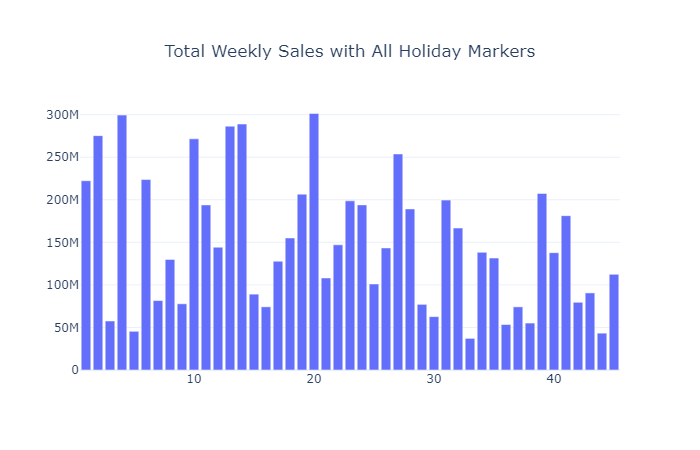

In [25]:
byStore_Bar = go.Figure(data=go.Bar(x=byStore.Store,
                                y=byStore.Weekly_Sales, 
                                name='Weekly_Sales')
)



byStore_Bar.update_layout(title={
        'text': "Total Weekly Sales with All Holiday Markers",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

byStore_Bar.show('png')
#byStore_Bar.show()

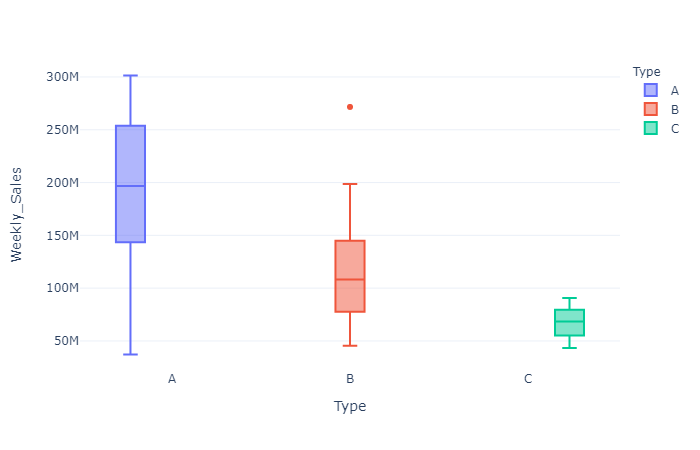

In [26]:
fig = px.box(byStore, x="Type", y="Weekly_Sales", color="Type")
fig.show('png')
#fig.show()

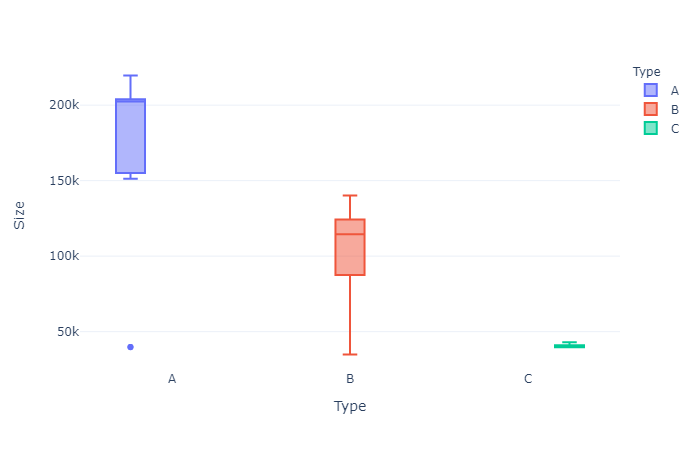

In [27]:
fig = px.box(byStore, x="Type", y="Size", color="Type")
fig.show('png')
#fig.show()

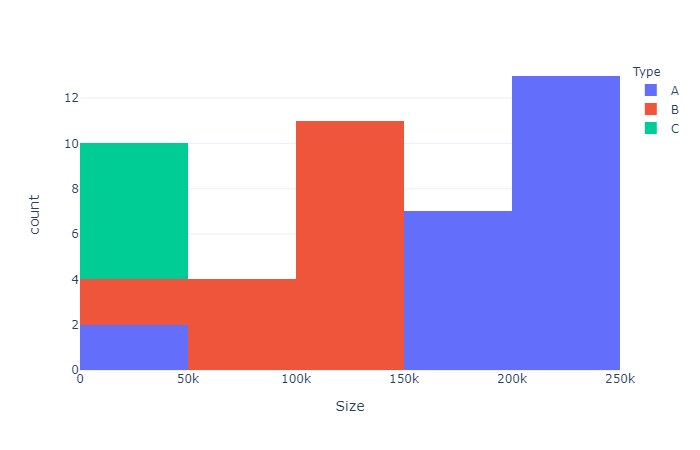

In [28]:
size_Dist = px.histogram(byStore, x="Size", color='Type')
size_Dist.show('png')
#size_Dist.show()

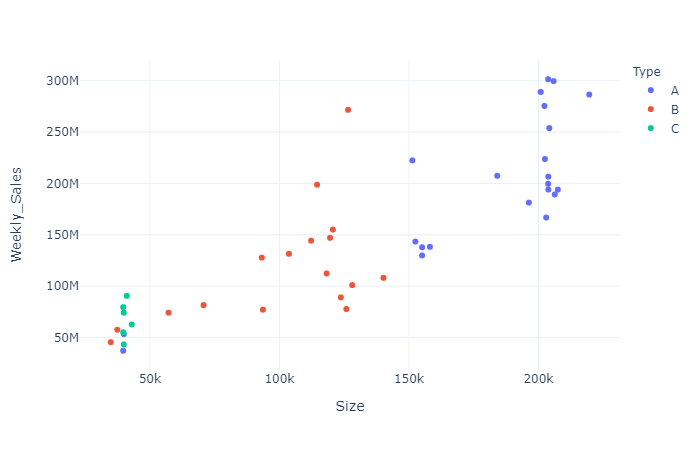

In [29]:
fig = px.scatter(byStore, x="Size",y='Weekly_Sales',color='Type')
fig.show('png')
#fig.show()

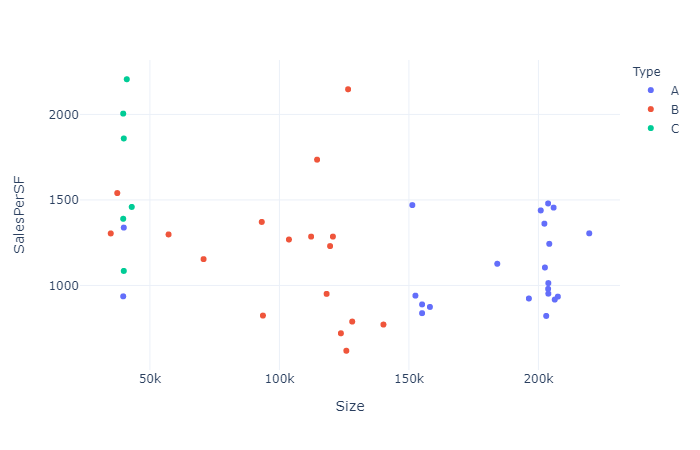

In [30]:
byStore['SalesPerSF'] = byStore.Weekly_Sales/byStore.Size

fig = px.scatter(byStore, x="Size",y='SalesPerSF',color='Type')
fig.show('png')
#fig.show()

## Cluster Stores

In [31]:
byStorex = byStore[['SalesPerSF','Weekly_Sales', 'Size']]
byStorex.head()

,SalesPerSF,Weekly_Sales,Size
0,1469.800144,2.224028e+08,151315
1,1361.210640,2.753824e+08,202307
2,1540.081704,5.758674e+07,37392
3,1455.064550,2.995440e+08,205863
4,1303.962406,4.547569e+07,34875


In [32]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6) 
kmeans.fit(byStorex)
byStorex['Cluster'] = kmeans.labels_
byStorex.head()

,SalesPerSF,Weekly_Sales,Size,Cluster
0,1469.800144,2.224028e+08,151315,1
1,1361.210640,2.753824e+08,202307,2
2,1540.081704,5.758674e+07,37392,4
3,1455.064550,2.995440e+08,205863,2
4,1303.962406,4.547569e+07,34875,4


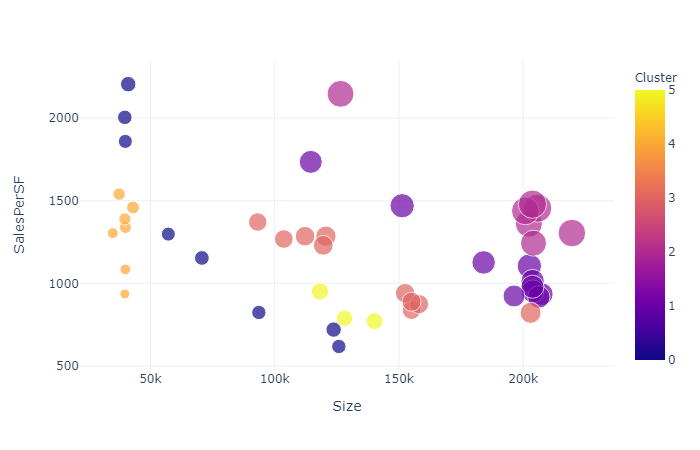

In [33]:
fig = px.scatter(byStorex, x="Size",y='SalesPerSF',color='Cluster', size='Weekly_Sales')
fig.show('png')
#fig.show()

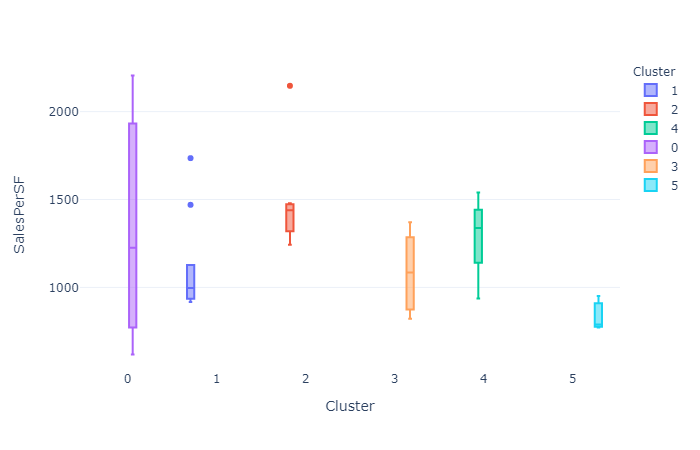

In [34]:
fig = px.box(byStorex, x="Cluster", y="SalesPerSF", color="Cluster")
fig.show('png')
#fig.show()

# Sales by Dept
Which departments are influenced by seasonality?

In [35]:
#number of unique departments
sales['Dept'].nunique()

81

In [36]:
byDept = sales.groupby(['Dept']).sum()
byDept.head()

,Store,Weekly_Sales,IsHoliday
Dept,,,
1,148005,1.236388e+08,450.0
2,148005,2.806112e+08,450.0
3,148005,7.589245e+07,450.0
4,148005,1.671467e+08,450.0
5,144441,1.356074e+08,443.0


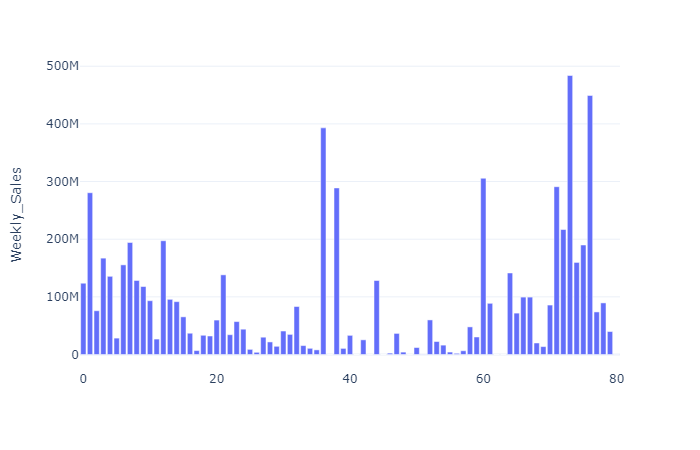

In [37]:
byDept_Bar = px.bar(byDept, y='Weekly_Sales')
byDept_Bar.show('png')
#byDept_Bar.show()

In [38]:
byDept.query('Weekly_Sales<=0')

,Store,Weekly_Sales,IsHoliday
Dept,,,
47,12641,-4962.93,55.0


## DICKEY-FULLER TEST
determine stationarity...lags!!

In [39]:
from statsmodels.tsa.stattools import adfuller

In [40]:
#salesx = pd.read_csv("data/sales.csv")
#salesx.head()

In [41]:
#median number of records for depts with NO missing week
sales.groupby('Dept').nunique().sort_values('Date').query('Date==143')['Weekly_Sales'].median()

5873.0

In [42]:
sales.Date.nunique()

143

In [43]:
#Depts with missing weeks
dept_w_missing_wks = sales.groupby('Dept').nunique().sort_values('Date').query('Date<143')
missing_wks = dept_w_missing_wks.index

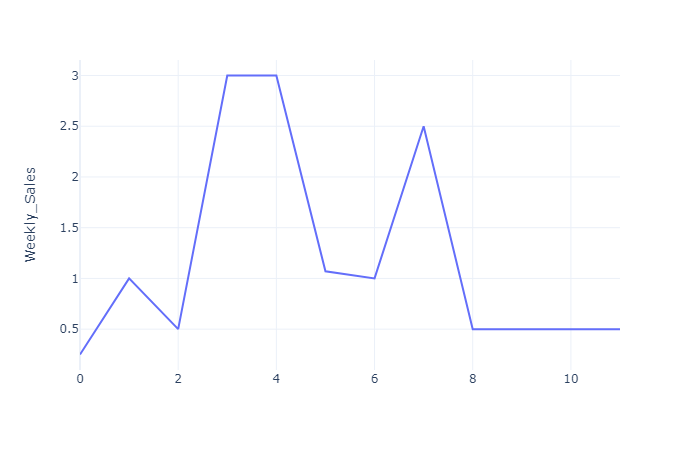

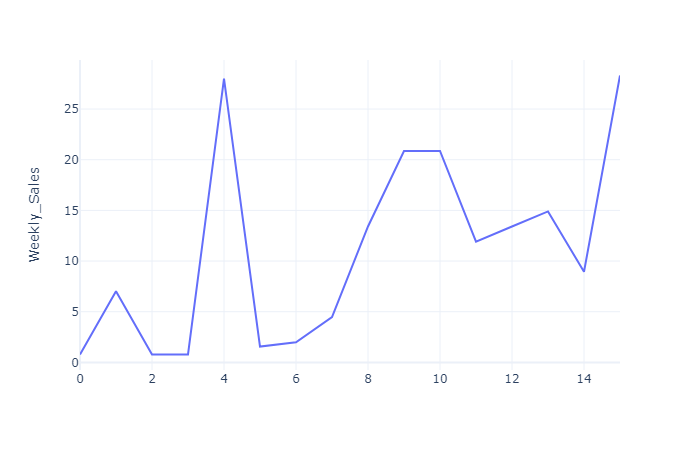

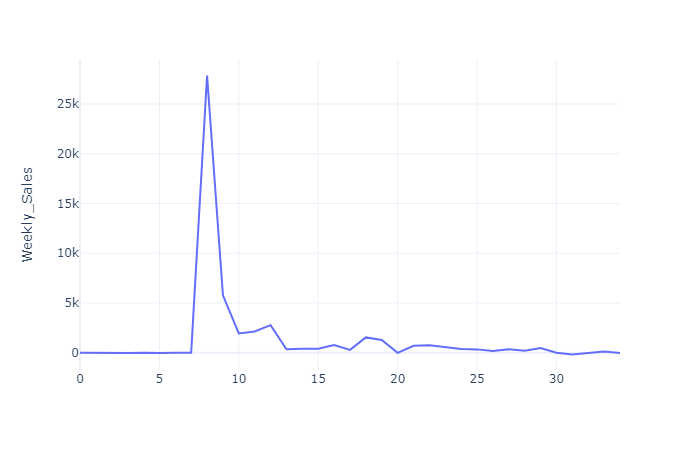

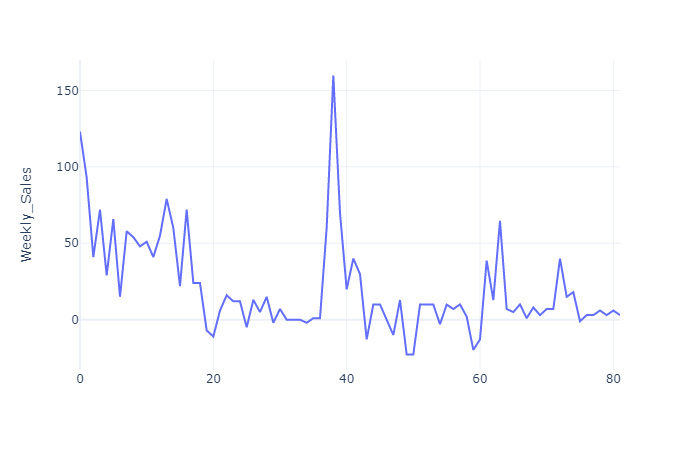

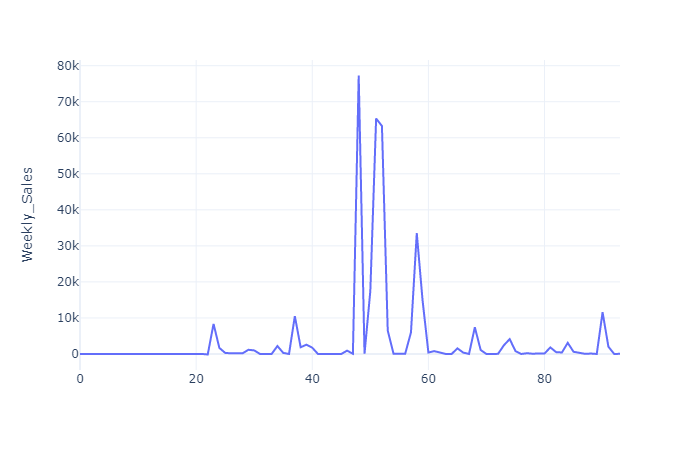

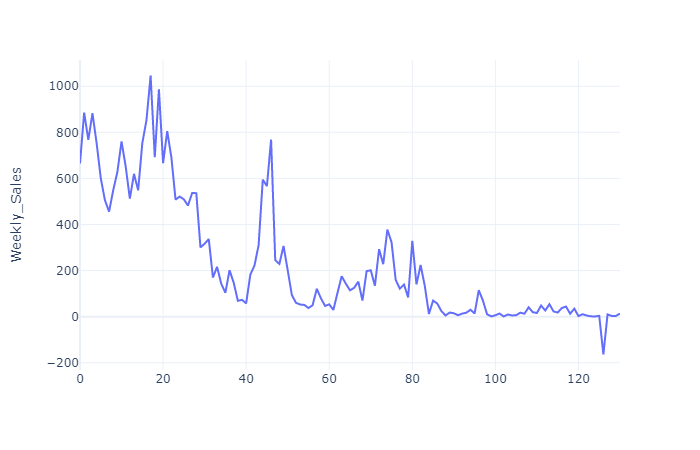

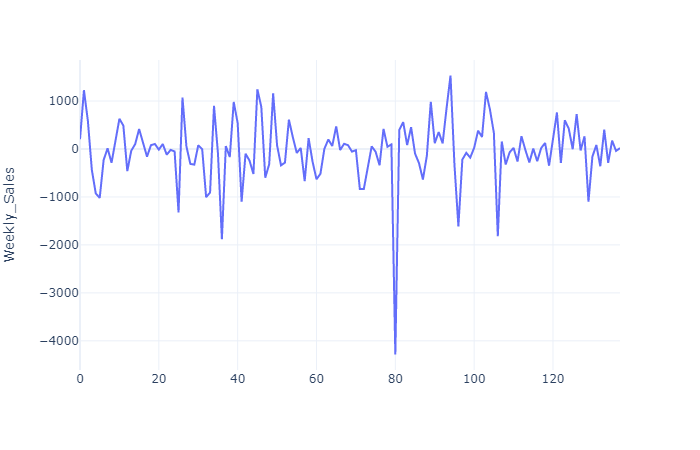

In [44]:
for dept in missing_wks:
    data = sales.query(f"Dept=={dept}").groupby('Date').sum()
    fig = px.line(data, y="Weekly_Sales")
    fig.show('png')

In [45]:
stat_list = []
stat_bool_list = []
dept_list = []
depts = sales.Dept.unique()
for dept in depts:
    if dept in missing_wks:
        continue
        
    byDeptx = sales.query(f"Dept=={dept}").groupby('Date').sum()
    dftest = adfuller(byDeptx['Weekly_Sales'], maxlag=55)
    p_value = dftest[1]
    lags = dftest[2]

    if p_value <= 0.05:
        stationarity = "Stationary"
        station_bool = 1
        
    else:
        stationarity = "Non-Stationary"
        station_bool = 0
    
    dept_list.append(dept)
    stat_list.append(stationarity)
    stat_bool_list.append(station_bool)

stationarities = pd.DataFrame({'Dept': dept_list,
                              'Stationary': stat_list,
                              'Stationary_Bool': stat_bool_list})
stationarities.head()

,Dept,Stationary,Stationary_Bool
0,1,Stationary,1
1,2,Non-Stationary,0
2,3,Non-Stationary,0
3,4,Non-Stationary,0
4,5,Non-Stationary,0


In [46]:
byStat = pd.merge(sales, stationarities, on='Dept', how='left')
byStat = byStat.groupby(['Stationary','Date'], as_index=False).sum()

byStat.head()

,Stationary,Date,Store,Dept,Weekly_Sales,IsHoliday,Stationary_Bool
0,Non-Stationary,2010-02-05,58915,122060,48039569.65,0.0,0.0
1,Non-Stationary,2010-02-12,58777,122443,46032611.95,2658.0,0.0
2,Non-Stationary,2010-02-19,59111,122932,46248198.63,0.0,0.0
3,Non-Stationary,2010-02-26,58787,121808,42400522.75,0.0,0.0
4,Non-Stationary,2010-03-05,58709,121288,45083785.01,0.0,0.0


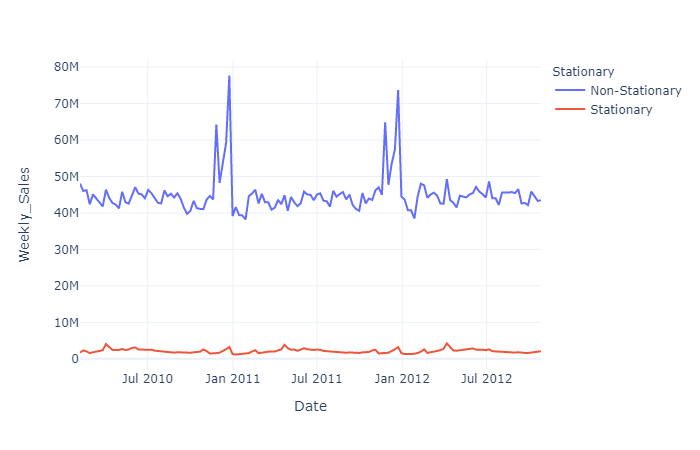

In [47]:
byStat_line = px.line(byStat,x='Date', y='Weekly_Sales', color='Stationary')
byStat_line.show('png')
#byStat_line.show()

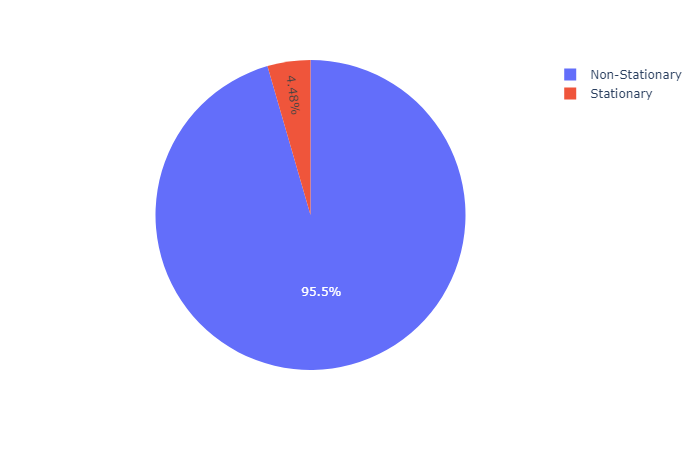

In [48]:
fig = px.pie(byStat, values='Weekly_Sales', names='Stationary')
fig.show('png')
#fig.show()

# 3. Forecasting

## Seasonal Decomposition

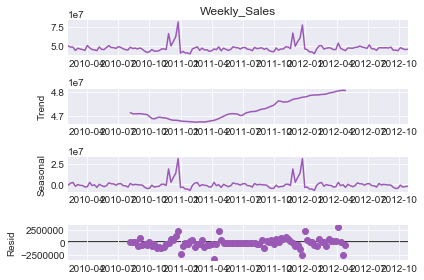

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(byDate['Weekly_Sales'], model='add')
result.plot();

# SARIMA

In [50]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from pmdarima import auto_arima    

In [51]:
models = byDate[['Weekly_Sales', 'IsHoliday']]
models.IsHoliday = byDate.IsHoliday.astype('bool').astype('int')
models.head()

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,49750740.50,0
2010-02-12,48336677.63,1
2010-02-19,48276993.78,0
2010-02-26,43968571.13,0
2010-03-05,46871470.30,0


In [52]:
models.index.freq = 'W-FRI'
models.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-FRI')

In [53]:
#confirm stationarity
adfuller(models['Weekly_Sales'], maxlag=55)

(0.5483968487251434,
 0.9862721701632599,
 52,
 90,
 {'1%': -3.505190196159122,
  '5%': -2.894232085048011,
  '10%': -2.5842101234567902},
 2791.5185459500194)

In [54]:
#Run pmdarima.auto_arima to obtain recommended orders
auto_arima(models['Weekly_Sales'],seasonal=True,m=52).summary()

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  143
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -2376.907
Date:                             Sat, 23 May 2020   AIC                           4767.813
Time:                                     22:33:58   BIC                           4788.553
Sample:                                          0   HQIC                          4776.241
                                             - 143                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.103e+07   1.59e-08   1.95e+15      0.000     3.1e+07     3.1e+07
ar.L1         -0.8263      0.277     -2.982      0.003      -1.370      -0.283
ar.L2         -0.1655      0.411     -0.403      0.687      -0.971       0.640
ma.L1          1.2206      0.284      4.303      0.000       0.665       1.777
ma.L2          0.6215      0.272      2.282      0.022       0.088       1.155
ar.S.L52       0.6713      0.041     16.271      0.000       0.590       0.752
sigma2      2.389e+13   1.82e-14   1.31e+27      0.000    2.39e+13    2.39e+13
===================================================================================
Ljung-Box (Q):                       24.98   Jarque-Bera (JB):               891.56
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.28e+43. Standard errors may be unstable.
"""

In [55]:
#Split the data into train/test setsdates = models.index
length = len(models)
train_len = int(length*0.70)

train = models.iloc[:train_len]
test = models.iloc[train_len:]

In [56]:
#Fit a SARIMA(1,0,0)(2,0,0,7) Model
model1 = SARIMAX(train['Weekly_Sales'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1689.821
Date:                             Sat, 23 May 2020   AIC                           3391.642
Time:                                     22:34:05   BIC                           3407.273
Sample:                                 02-05-2010   HQIC                          3397.968
                                      - 12-30-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1068      0.777      0.137      0.891      -1.416       1.629
ar.L2          0.8824      0.789      1.119      0.263      -0.664       2.428
ma.L1          0.2689      0.816      0.330      0.742      -1.330       1.868
ma.L2         -0.4637      0.603     -0.769      0.442      -1.645       0.717
ar.S.L52       0.6050      0.072      8.364      0.000       0.463       0.747
sigma2      3.569e+13   4.95e-14   7.22e+26      0.000    3.57e+13    3.57e+13
===================================================================================
Ljung-Box (Q):                       30.30   Jarque-Bera (JB):               489.01
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                             0.12
Prob(H) (two-sided):                  0.62   Kurtosis:                        13.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.87e+42. Standard errors may be unstable.
"""

In [57]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions1 = results.predict(start=start, end=end, dynamic=False)
models['NoHolidays'] = predictions1
models.dropna(inplace=True)
models.head()

,Weekly_Sales,IsHoliday,NoHolidays
Date,,,
2012-01-06,44955421.95,0,4.955957e+07
2012-01-13,42023078.48,0,4.718369e+07
2012-01-20,42080996.56,0,4.790317e+07
2012-01-27,39834974.67,0,4.636877e+07
2012-02-03,46085608.09,0,5.088296e+07


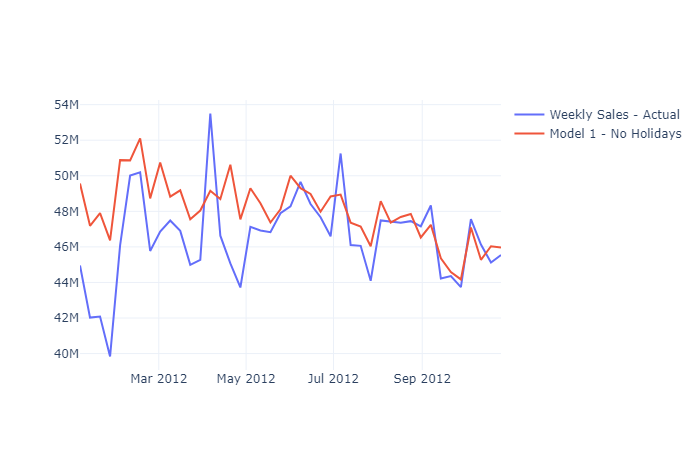

In [58]:
models_lines = go.Figure()

models_lines.add_trace(
    go.Scatter(
        x=models.index,
        y=models.Weekly_Sales,
        name = "Weekly Sales - Actual"
    ))

models_lines.add_trace(
    go.Scatter(
        x=models.index,
        y=models.NoHolidays,
        name = "Model 1 - No Holidays"
    ))

models_lines.show('png')
#models_lines.show()

In [59]:
from statsmodels.tools.eval_measures import mse,rmse

mse1 = mse(test['Weekly_Sales'], predictions1)
rmse1 = rmse(test['Weekly_Sales'], predictions1)

print(f"MSE: {mse1}\nRMSE: {rmse1}")

MSE: 6972944323732.732
RMSE: 2640633.3186818524


# SARIMAX - WalMart Holidays
add the exog variable

In [60]:
model2 = SARIMAX(train['Weekly_Sales'],exog=train['IsHoliday'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model2.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1775.497
Date:                             Sat, 23 May 2020   AIC                           3564.994
Time:                                     22:34:13   BIC                           3583.231
Sample:                                 02-05-2010   HQIC                          3572.375
                                      - 12-30-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday   5.087e+07   1.83e-08   2.78e+15      0.000    5.09e+07    5.09e+07
ar.L1          0.0009      0.131      0.006      0.995      -0.256       0.258
ar.L2          0.9991      0.134      7.466      0.000       0.737       1.261
ma.L1          0.0077      0.639      0.012      0.990      -1.244       1.259
ma.L2         -0.9963      0.351     -2.840      0.005      -1.684      -0.309
ar.S.L52       0.5931      0.142      4.163      0.000       0.314       0.872
sigma2       2.12e+14   1.36e-15   1.55e+29      0.000    2.12e+14    2.12e+14
===================================================================================
Ljung-Box (Q):                       38.45   Jarque-Bera (JB):               410.79
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.30   Skew:                            -2.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.62e+45. Standard errors may be unstable.
"""

In [61]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['IsHoliday']]  # requires two brackets to yield a shape of (35,1)
predictions2 = results.predict(start=start, end=end, exog=exog_forecast)
models['WalmartHolidays'] = predictions2
models.head()

,Weekly_Sales,IsHoliday,NoHolidays,WalmartHolidays
Date,,,,
2012-01-06,44955421.95,0,4.955957e+07,4.327769e+07
2012-01-13,42023078.48,0,4.718369e+07,4.131636e+07
2012-01-20,42080996.56,0,4.790317e+07,4.201861e+07
2012-01-27,39834974.67,0,4.636877e+07,4.067970e+07
2012-02-03,46085608.09,0,5.088296e+07,4.527893e+07


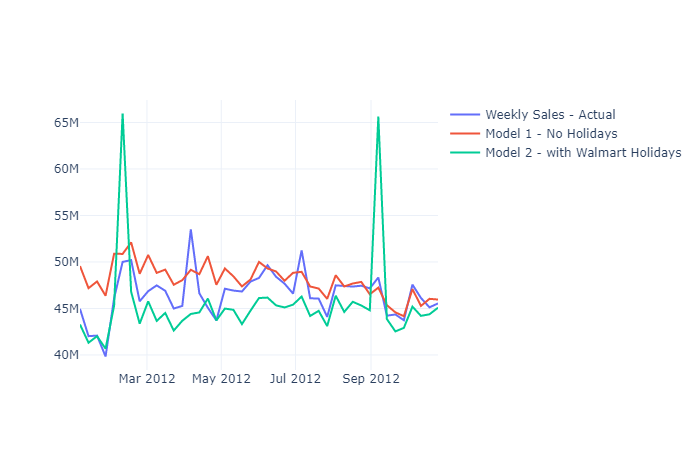

In [62]:
models_lines.add_trace(
    go.Scatter(
        x=models.index,
        y=models.WalmartHolidays,
        name = "Model 2 - with Walmart Holidays"
    ))
models_lines.show('png')
#models_lines.show()

In [63]:
testmin = test.index.min()
testmax = test.index.max()
trainmin = train.index.min()
trainmax = train.index.max()

print(f"Train Set: {trainmin} - {trainmax}\nTest Set: {testmin} - {testmax}")

Train Set: 2010-02-05 00:00:00 - 2011-12-30 00:00:00
Test Set: 2012-01-06 00:00:00 - 2012-10-26 00:00:00


In [64]:
mse2 = mse(test['Weekly_Sales'], predictions2)
rmse2 = rmse(test['Weekly_Sales'], predictions2)

print(f"MSE: {mse2}\nRMSE: {rmse2}")

MSE: 19198328439194.598
RMSE: 4381589.715981472


# SARIMAX - All Holidays
add the exog variable

In [65]:
byDatex = sales_all.groupby('Date').sum()
byDatex.IsHoliday = byDatex.IsHoliday.astype('bool').astype('int')
byDatex.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-02-05,65124,130557,49750740.50,0
2010-02-12,65082,131179,48336677.63,1
2010-02-19,65610,131897,48276993.78,1
2010-02-26,65045,130161,43968571.13,0
2010-03-05,64897,129670,46871470.30,0


In [66]:
#Split the data into train/test setsDatexs = byDatex.index
length = len(byDatex)
train_len = int(length*0.70)

train = byDatex.iloc[:train_len]
test = byDatex.iloc[train_len:]

In [67]:
model3 = SARIMAX(train['Weekly_Sales'],exog=train['IsHoliday'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model3.fit()
results.summary()

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.

C:\Users\octav\AppData\Local\Continuum\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency W-FRI will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                        Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(2, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1824.782
Date:                             Sat, 23 May 2020   AIC                           3663.564
Time:                                     22:34:21   BIC                           3681.800
Sample:                                 02-05-2010   HQIC                          3670.945
                                      - 12-30-2011                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
IsHoliday   4.912e+07   1.89e-07    2.6e+14      0.000    4.91e+07    4.91e+07
ar.L1          0.0231      1.297      0.018      0.986      -2.519       2.566
ar.L2          0.9766      1.297      0.753      0.452      -1.566       3.519
ma.L1         -0.0078      1.183     -0.007      0.995      -2.326       2.310
ma.L2         -0.9697      1.175     -0.825      0.409      -3.272       1.333
ar.S.L52       0.5249      0.191      2.742      0.006       0.150       0.900
sigma2      5.609e+14   4.84e-15   1.16e+29      0.000    5.61e+14    5.61e+14
===================================================================================
Ljung-Box (Q):                       55.67   Jarque-Bera (JB):                 9.33
Prob(Q):                              0.05   Prob(JB):                         0.01
Heteroskedasticity (H):               0.42   Skew:                            -0.75
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.99e+46. Standard errors may be unstable.
"""

In [68]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
exog_forecast = test[['IsHoliday']]  # requires two brackets to yield a shape of (35,1)
predictions3 = results.predict(start=start, end=end, exog=exog_forecast)
models['AllHolidays'] = predictions3
models.head()

,Weekly_Sales,IsHoliday,NoHolidays,WalmartHolidays,AllHolidays
Date,,,,,
2012-01-06,44955421.95,0,4.955957e+07,4.327769e+07,6.212013e+07
2012-01-13,42023078.48,0,4.718369e+07,4.131636e+07,3.730247e+07
2012-01-20,42080996.56,0,4.790317e+07,4.201861e+07,3.765549e+07
2012-01-27,39834974.67,0,4.636877e+07,4.067970e+07,3.674286e+07
2012-02-03,46085608.09,0,5.088296e+07,4.527893e+07,4.052890e+07


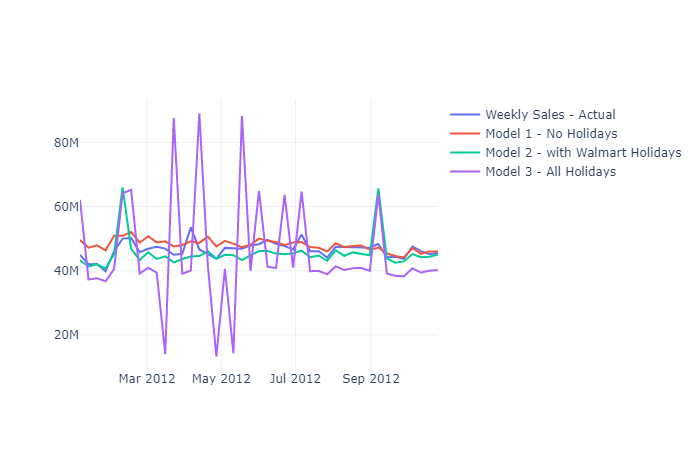

In [69]:
models_lines.add_trace(
    go.Scatter(
        x=models.index,
        y=models.AllHolidays,
        name = "Model 3 - All Holidays"
    ))
models_lines.show('png')
#models_lines.show()

In [70]:
from statsmodels.tools.eval_measures import mse,rmse

In [71]:
mse3 = mse(test['Weekly_Sales'], predictions3)
rmse3 = rmse(test['Weekly_Sales'], predictions3)

print(f"MODEL 1\n MSE: {mse1}\n RMSE: {rmse1}\n")
print(f"MODEL 2\n MSE: {mse2}\n RMSE: {rmse2}\n")
print(f"MODEL 3\n MSE: {mse3}\n RMSE: {rmse3}")

MODEL 1
 MSE: 6972944323732.732
 RMSE: 2640633.3186818524

MODEL 2
 MSE: 19198328439194.598
 RMSE: 4381589.715981472

MODEL 3
 MSE: 264049956357212.47
 RMSE: 16249614.037176775


## Forecast the Future

#### Retrain all data on Model 1

In [72]:
byDate = byDate[['Weekly_Sales','IsHoliday']]
byDate.head()

,Weekly_Sales,IsHoliday
Date,,
2010-02-05,49750740.50,0
2010-02-12,48336677.63,1
2010-02-19,48276993.78,0
2010-02-26,43968571.13,0
2010-03-05,46871470.30,0


In [73]:
csv = pd.read_csv("data/fcast.csv")
fcast_dates = pd.DataFrame(csv)
fcast_dates.IsHoliday = fcast_dates.IsHoliday.astype('bool').astype('int')
fcast_dates.Date = pd.to_datetime(fcast_dates.Date)
fcast_dates.head()

,Date,IsHoliday
0,2012-11-02,0
1,2012-11-09,0
2,2012-11-16,0
3,2012-11-23,1
4,2012-11-30,0


In [74]:
fcast_dates.set_index('Date', inplace=True)
fcast_dates.index.freq = 'W-FRI'
fcast_dates.index

DatetimeIndex(['2012-11-02', '2012-11-09', '2012-11-16', '2012-11-23',
               '2012-11-30', '2012-12-07', '2012-12-14', '2012-12-21',
               '2012-12-28', '2013-01-04', '2013-01-11', '2013-01-18',
               '2013-01-25', '2013-02-01', '2013-02-08', '2013-02-15',
               '2013-02-22', '2013-03-01', '2013-03-08', '2013-03-15',
               '2013-03-22', '2013-03-29', '2013-04-05', '2013-04-12',
               '2013-04-19', '2013-04-26', '2013-05-03', '2013-05-10',
               '2013-05-17', '2013-05-24', '2013-05-31', '2013-06-07',
               '2013-06-14', '2013-06-21', '2013-06-28', '2013-07-05',
               '2013-07-12', '2013-07-19', '2013-07-26'],
              dtype='datetime64[ns]', name='Date', freq='W-FRI')

In [75]:
byDate.index

DatetimeIndex(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
               '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
               '2010-04-02', '2010-04-09',
               ...
               '2012-08-24', '2012-08-31', '2012-09-07', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-10-05', '2012-10-12',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=143, freq='W-FRI')

In [76]:
len(fcast_dates)
len(test)

43

In [77]:
model2x = SARIMAX(byDate['Weekly_Sales'],order=(2,0,2),seasonal_order=(1,0,0,52),enforce_invertibility=False)
results = model2x.fit()
exog_forecast = fcast_dates[['IsHoliday']]
fcast_predics = results.predict(fcast_dates.index.min(),fcast_dates.index.max(),exog=exog_forecast)

In [78]:
fcast_dates['Weekly_Sales'] = fcast_predics
fcast_dates['SalesType'] = "Forecast"
fcast_dates.head()

,IsHoliday,Weekly_Sales,SalesType
Date,,,
2012-11-02,0,4.755957e+07,Forecast
2012-11-09,0,4.741273e+07,Forecast
2012-11-16,0,4.587483e+07,Forecast
2012-11-23,1,5.970198e+07,Forecast
2012-11-30,0,4.774500e+07,Forecast


In [79]:
byDate['SalesType'] = "Actual"
byDate.head()

,Weekly_Sales,IsHoliday,SalesType
Date,,,
2010-02-05,49750740.50,0,Actual
2010-02-12,48336677.63,1,Actual
2010-02-19,48276993.78,0,Actual
2010-02-26,43968571.13,0,Actual
2010-03-05,46871470.30,0,Actual


In [80]:
byDateFcast = pd.concat([byDate,fcast_dates])
byDateFcast

,IsHoliday,SalesType,Weekly_Sales
Date,,,
2010-02-05,0,Actual,4.975074e+07
2010-02-12,1,Actual,4.833668e+07
2010-02-19,0,Actual,4.827699e+07
2010-02-26,0,Actual,4.396857e+07
2010-03-05,0,Actual,4.687147e+07
...,...,...,...
2013-06-28,0,Forecast,4.358655e+07
2013-07-05,0,Forecast,4.672122e+07
2013-07-12,0,Forecast,4.310799e+07


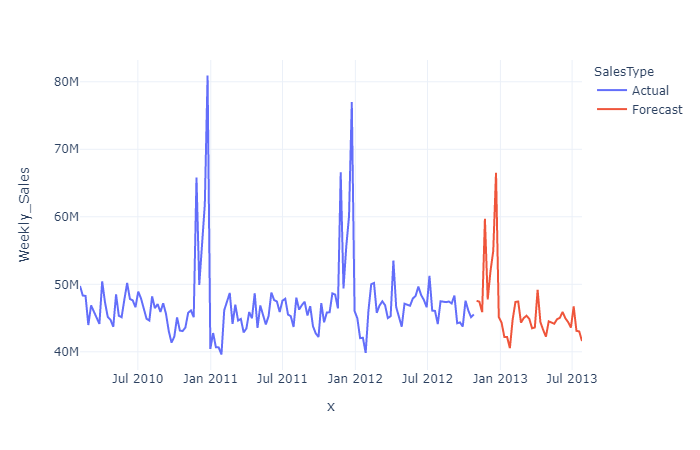

In [81]:
fcast_line = px.line(byDateFcast, x=byDateFcast.index,y='Weekly_Sales', color='SalesType')
fcast_line.show('png')
#fcast_line.show()